In [1]:
from io import BytesIO

import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = models.resnet34(pretrained=True).to(device)
model = models.vgg16(pretrained=True).to(device)
!nvidia-smi

Wed Jul 24 21:21:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.116                Driver Version: 390.116                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P2    30W /  N/A |    957MiB /  6078MiB |     49%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [55]:
input_size = 512

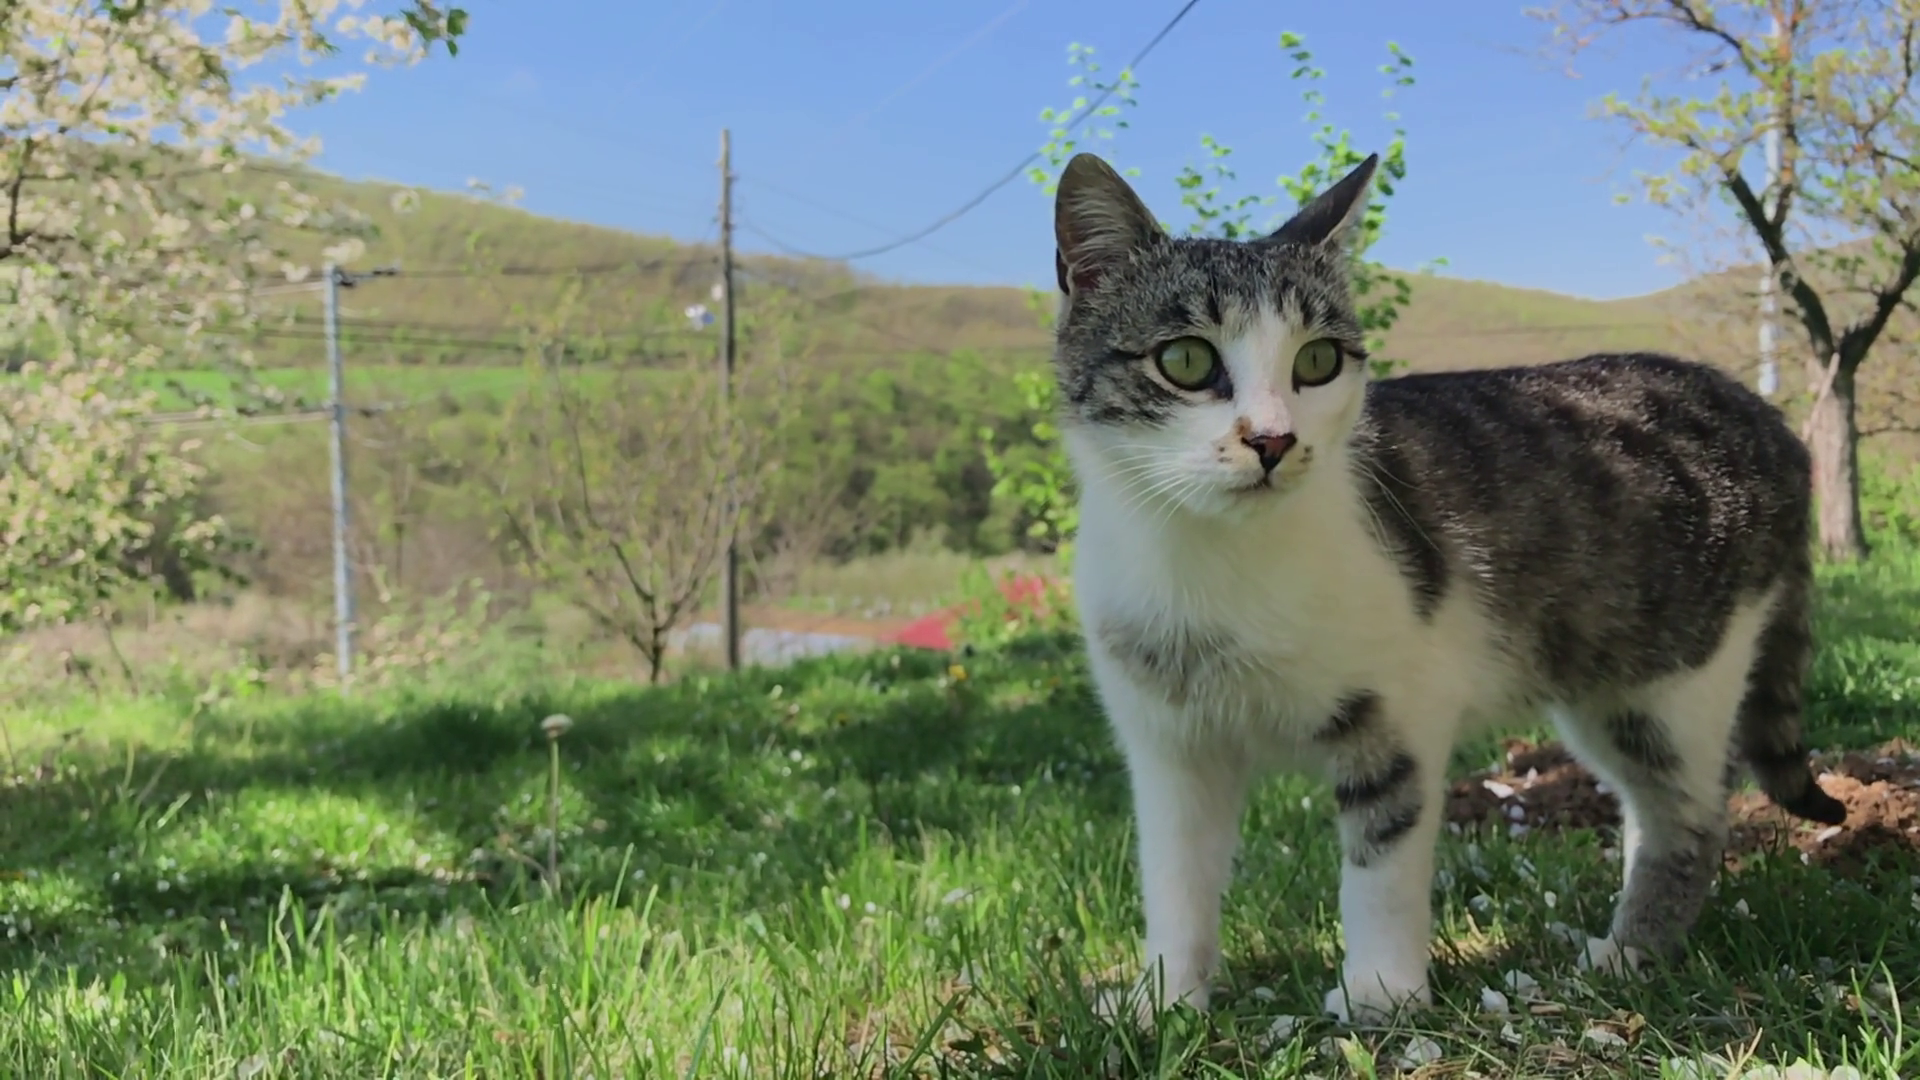

In [56]:
cat_url = 'https://images.pexels.com/photos/259803/pexels-photo-259803.jpeg'
animals_url = 'https://rukminim1.flixcart.com/image/704/704/jv2p6kw0/book/0/1/0/domestic-animals-original-imafgfh9yfjhtgeh.jpeg'
cat2_url = 'https://d2v9y0dukr6mq2.cloudfront.net/video/thumbnail/IoehFAQ/videoblocks-sunny-day-outdoor-gray-and-white-domestic-animals-in-slow-motion-1920x1080-_hsyyj8zbb_thumbnail-full08.png'

response = requests.get(cat2_url)
image = Image.open(BytesIO(response.content))
image

In [57]:
transform = transforms.Compose([
    transforms.Resize(input_size, Image.LANCZOS),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [58]:
print(image.size)
x = transform(image)
print(x.shape)
cat_batch = x[None].to(device)
print(batch.shape)

(1920, 1080)
torch.Size([3, 512, 512])
torch.Size([1, 3, 56, 56])


In [7]:
model.eval()
with torch.no_grad():
    logits = model(batch)
    probabilities = logits.softmax(1).squeeze()
    top_probs, top_idx = probabilities.topk(5)
    top_idx = top_idx.cpu().numpy().squeeze()

In [8]:
response = requests.get('https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json')
classes = np.array(response.json())

In [9]:
# predicted_classes = classes[top_idx].tolist()
for prob, idx in zip(top_probs, top_idx):
    print(f'{prob * 100:.2f}% {classes[idx]}')

23.89% Alaskan Malamute
19.92% Siberian Husky
11.82% coyote
11.09% Australian Kelpie
9.11% grey wolf


## Activations

In [10]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

# model.conv1.register_forward_hook(get_activation('conv1'))
# model.layer4[2].relu.register_forward_hook(get_activation('layer4_2_relu'));
model.features[29].register_forward_hook(get_activation('layer29'));

In [12]:
with torch.no_grad():
    model(batch)
features = activation['layer29'].squeeze()
features.shape

torch.Size([512, 3, 3])

In [13]:
mean_activations = features.mean(dim=(1, 2)).squeeze()
print(mean_activations.shape)
values, indices = torch.topk(mean_activations, 5)
print(values)
print(indices)

torch.Size([512])
tensor([6.5673, 4.7754, 4.6977, 3.5769, 3.4963], device='cuda:0')
tensor([328,  86, 151, 290,  10], device='cuda:0')


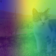

In [14]:
def grey2rgb(grey, mask=None):
    rgb = plt.cm.viridis(grey / grey.max(), bytes=True)[..., :-1]
    return rgb

transform_pil = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
])

def upsample(tensor, reference_image):
    array = tensor.squeeze().cpu().numpy()
    array -= array.min()
    array /= array.max()
    array *= 255
    array = array.astype(np.uint8)
    rgb = grey2rgb(array)
    image = Image.fromarray(rgb)
    image = image.resize(reference_image.size, Image.LANCZOS)
    return image
# for feature in features:
top = 0
index = indices[top]
ref_image = transform_pil(image)
activation_map = upsample(features[index], ref_image)
Image.blend(ref_image, activation_map, 0.75)

## Feature visualization

In [47]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True)
    def close(self):
        self.hook.remove()

In [43]:
def tensor_to_image(tensor, path=None):
    input_to_image = tensor.cpu().detach().numpy().squeeze()
    input_to_image = input_to_image.transpose(1, 2, 0)
    input_to_image -= input_to_image.min()
    input_to_image /= input_to_image.max()
    input_to_image *= 255
    input_to_image = input_to_image.astype(np.uint8)
    input_to_image = Image.fromarray(input_to_image)
    if path is not None:
        input_to_image.save(path)
    return input_to_image

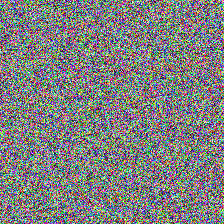

In [88]:
input_size = 224

transform = transforms.Compose([
    transforms.Resize(input_size, Image.LANCZOS),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

spatial_transform = transforms.Compose([
    transforms.Resize(input_size, Image.LANCZOS),
    transforms.CenterCrop(input_size),
])

random_array = np.random.randint(0, 256, (input_size, input_size, 3), np.uint8)
random_image = Image.fromarray(random_array)
random_image

turtle


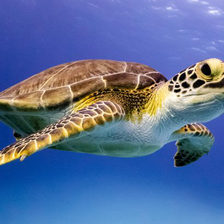

74.09% loggerhead sea turtle
24.04% leatherback sea turtle
0.59% terrapin
0.35% great white shark
0.17% garfish
Mean activation: 0.27

fish


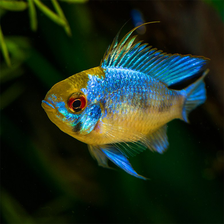

90.31% goldfish
8.29% pufferfish
0.75% rock beauty
0.26% tench
0.12% coral reef
Mean activation: 2.34

eagle


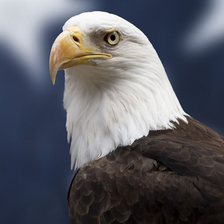

99.76% bald eagle
0.24% kite
0.00% vulture
0.00% hornbill
0.00% albatross
Mean activation: 0.22

parrot


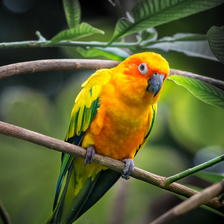

56.96% lorikeet
42.48% macaw
0.33% bee eater
0.05% toucan
0.05% goldfinch
Mean activation: 0.39



In [91]:
feature_index = 100
for name in ('turtle', 'fish', 'eagle', 'parrot'):
    print(name)
    filepath = f'/tmp/{name}.jpg'
    image = Image.open(filepath)
    small = spatial_transform(image)
    display(small)
    batch = transform(image)[None].to(device)
    with torch.no_grad():
        logits = model(batch)
        probabilities = logits.softmax(1).squeeze()
        top_probs, top_idx = probabilities.topk(5)
        top_idx = top_idx.cpu().numpy().squeeze()
        for prob, idx in zip(top_probs, top_idx):
            print(f'{prob * 100:.2f}% {classes[idx]}')
        x = activation['layer29'][0, feature_index, ...].mean().item()
        print(f'Mean activation: {x:.2f}')
        print()

In [75]:
random_input = transform(random_image)[None].to(device)

new_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

/home/fernando/miniconda3/envs/episurg/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 20/20 [00:01<00:00, 10.70it/s]


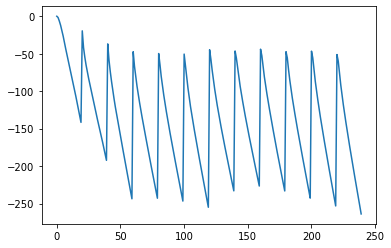

In [76]:
from pathlib import Path
from tqdm import trange
from PIL import ImageFilter

top = 0


# random_input = torch.tensor(cat_batch, requires_grad=True)


output_dir = Path('/tmp/vis')
if output_dir.is_dir():
    import shutil
    shutil.rmtree(output_dir)
output_dir.mkdir(exist_ok=True)

# activations = SaveFeatures(model.layer4[2].relu)
# with torch.no_grad():
#     print(activations.features.shape)
#     mean_activations = activations.features.mean(dim=(2, 3)).squeeze()
#     print(mean_activations.shape)
#     values, indices = torch.topk(mean_activations, 5)
#     print(values)
#     print(indices)

# index = indices[top]

model.eval()


iterations = 40
scales = 12
factor = 1.2
losses = []


feature_index = 101


n = 0
for scale_index in range(scales):
    random_input = torch.tensor(random_input, requires_grad=True)
    optimizer = optim.Adam([random_input], lr=1e-1, weight_decay=1e-6)
    for i in trange(iterations):
        optimizer.zero_grad()
        model(random_input)
    #     loss = -activations.features[0, index].mean()
        loss = -activation['layer29'][0, feature_index, ...].mean()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        if i % 10 == 0:
            path = output_dir / f'iter_{n:04d}.png'
            tensor_to_image(random_input, path=path)
            n += 1
    random_input = random_input.detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    random_input -= random_input.min()
    random_input /= random_input.max()
    random_input *= 255
    random_input = random_input.astype(np.uint8)
    
    image = Image.fromarray(random_input)
    new_size = np.round(factor * np.array(image.size)).astype(np.uint16)
    image = image.resize(new_size, Image.LANCZOS)
#     image = image.filter(ImageFilter.BLUR)
    normalized = new_transform(image)
    random_input = normalized.to(device)[None]
#     iterations *= .85
    iterations = np.round(iterations).astype(int)
    
# activations.close()
plt.plot(losses)

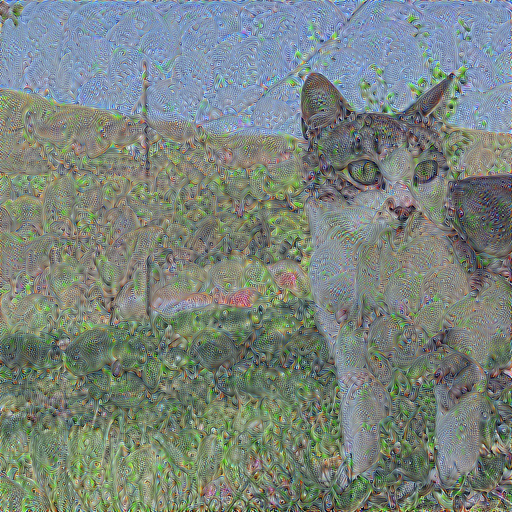

In [66]:
alpha = 0.1
blended = alpha * random_input + (1 - alpha) * cat_batch
tensor_to_image(blended, path='/tmp/blend.png')

## Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps

In [ ]:
augment = transforms.Compose([
    transforms.Pad(16, padding_mode='reflect'),
    transforms.RandomAffine(0, scale=(0.95, 1.05)),
    transforms.RandomRotation(5, resample=Image.BILINEAR),
    transforms.CenterCrop(input_size),
])
augment(im)

In [ ]:
idx = classes.tolist().index('zebra')
output_dir = Path('/tmp/vis')
output_dir.mkdir(exist_ok=True)

random_array = np.random.randint(0, 256, (input_size, input_size, 3), np.uint8)
random_image = Image.fromarray(random_array)
random_input = transform(random_image)[None]
original_image = tensor_to_image(random_input)
losses = []
if output_dir.is_dir():
    import shutil
    shutil.rmtree(output_dir)
output_dir.mkdir()

In [ ]:
iterations = 1000
optimizer = optim.Adam([random_input], lr=0.1)
for i in trange(iterations):
    optimizer.zero_grad()
    im = transforms.ToPILImage()(random_input.squeeze().detach().cpu())
    im = augment(im)
    random_input = transforms.ToTensor()(im)[None].to(device).requires_grad_(True)
    logits = model(random_input)
    loss = -logits[0, idx]# - lambda_ * torch.sqrt(torch.sum(random_input**2))
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    path = output_dir / f'iter_{i}.jpg'
    save_tensor_as_image(random_input, path)
plt.plot(-np.array(losses))

In [ ]:
tensor_to_image(random_input)

In [ ]:
with torch.no_grad():
    logits = model(random_input)
    posteriors = logits.softmax(1)
posteriors[0]